Mar 9

Create datasets with more classes, train on them and inspect
the results on rare classes. Does it affect the performance on
frequent classes?

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime
from pathlib import Path
from random import shuffle
from typing import List, Tuple

import numpy as np
import pandas as pd
import torch
from IPython.core.display import display, HTML
from jinja2 import Template
from matplotlib import pyplot
from sklearn.metrics import precision_score, recall_score, f1_score
from torch import tensor, Tensor
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from classifier import Classifier, debug
from dao.ower.ower_dir import Sample, OwerDir
from dao.ryn.ryn_dir import RynDir
from util import plot_tensor

pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 2)

# Config

In [2]:
ower_dataset = 'ower-v3-fb-irt-3-8'
ower_dir_path = Path(f'data/ower/{ower_dataset}')
class_count = 8
sent_count = 3

ryn_dir_path = Path(f'data/ryn/irt.fb.irt.5.clean')

# vectors = None
# vectors = 'charngram.100d'
# vectors = 'fasttext.en.300d'
# vectors = 'fasttext.simple.300d'
# vectors = 'glove.42B.300d'
# vectors = 'glove.840B.300d'
# vectors = 'glove.twitter.27B.25d'
# vectors = 'glove.twitter.27B.50d'
# vectors = 'glove.twitter.27B.100d'
vectors = 'glove.twitter.27B.200d'
# vectors = 'glove.6B.50d'
# vectors = 'glove.6B.100d'
# vectors = 'glove.6B.200d'
# vectors = 'glove.6B.300d'

emb_size = None
# emb_size = 200

batch_size = 1024
sent_len = 64

lr = 0.1
epoch_count = 1000

log_dir = 'runs/' + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + \
          f'_{ower_dataset}_emb-{emb_size}'

# 1 Build train/valid DataLoaders

In [3]:
ower_dir = OwerDir('OWER Dataset Directory', ower_dir_path, class_count, sent_count)
ower_dir.check()

train_set: List[Sample]
valid_set: List[Sample]

train_set, valid_set, _, vocab = ower_dir.read_datasets(vectors=vectors)

#
# Create dataloaders
#

def generate_batch(batch: List[Sample]) -> Tuple[Tensor, Tensor, Tensor]:

    ent_batch, gt_classes_batch, tok_lists_batch = zip(*batch)

    cropped_tok_lists_batch = [[tok_list[:sent_len]
                                for tok_list in tok_lists] for tok_lists in tok_lists_batch]

    padded_tok_lists_batch = [[tok_list + [0] * (sent_len - len(tok_list))
                               for tok_list in tok_lists] for tok_lists in cropped_tok_lists_batch]

    for padded_tok_lists in padded_tok_lists_batch:
        shuffle(padded_tok_lists)

    return tensor(ent_batch), tensor(padded_tok_lists_batch), tensor(gt_classes_batch)

train_loader = DataLoader(train_set, batch_size=batch_size, collate_fn=generate_batch, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, collate_fn=generate_batch)

#
# Calc class freqs and set class weights
#

_, train_classes_stack, _ = zip(*train_set)
train_classes_stack = np.array(train_classes_stack)
train_freqs = train_classes_stack.mean(axis=0)

class_weights = tensor(1 / train_freqs)
class_weights

c:\users\tobias\documents\hsrm\master\thesis\thesis-tools\venv\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
c:\users\tobias\documents\hsrm\master\thesis\thesis-tools\venv\lib\site-packages\torchtext\data\example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
c:\users\tobias\documents\hsrm\master\thesis\thesis-tools\venv\lib\site-packages\torchtext\data\example.py:78: UserWarning: Example clas

tensor([ 4.2348,  4.7659,  4.9241,  5.4442,  8.5908,  9.5545, 10.9580, 10.9381],
       dtype=torch.float64)

# 2 Create classifier

In [4]:
if vocab.vectors is None:
    classifier = Classifier.from_random(len(vocab), emb_size, class_count)
else:
    classifier = Classifier.from_pre_trained(vocab, class_count)

debug['enabled'] = True
print(classifier)

Classifier(
  (embedding_bag): EmbeddingBag(112622, 200, mode=mean)
)


# 3 Training

In [5]:
# criterion = MSELoss()
criterion = BCEWithLogitsLoss(pos_weight=class_weights)

# optimizer = SGD(classifier.parameters(), lr=lr)
optimizer = Adam(classifier.parameters(), lr=lr)

writer = SummaryWriter(log_dir=log_dir)

for epoch in range(epoch_count):

    #
    # Train
    #

    # Train loss across all batches
    train_loss = 0.0

    # Valid gt/pred classes across all batches
    train_gt_classes_stack: List[List[int]] = []
    train_pred_classes_stack: List[List[int]] = []

    for _, sents_batch, gt_classes_batch in tqdm(train_loader):
        logits_batch = classifier(sents_batch)

        loss = criterion(logits_batch, gt_classes_batch.float())
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred_classes_batch = (logits_batch > 0).int()

        train_gt_classes_stack += gt_classes_batch.numpy().tolist()
        train_pred_classes_stack += pred_classes_batch.numpy().tolist()

    #
    # Validate
    #

    # Valid loss across all batches
    valid_loss = 0.0

    # Valid gt/pred classes across all batches
    valid_gt_classes_stack: List[List[int]] = []
    valid_pred_classes_stack: List[List[int]] = []

    with torch.no_grad():
        for batch_idx, (ent_batch, sents_batch, gt_classes_batch) in enumerate(tqdm(valid_loader)):
            logits_batch = classifier(sents_batch)

            loss = criterion(logits_batch, gt_classes_batch.float())
            valid_loss += loss.item()

            pred_classes_batch = (logits_batch > 0).int()

            valid_gt_classes_stack += gt_classes_batch.numpy().tolist()
            valid_pred_classes_stack += pred_classes_batch.numpy().tolist()

    #
    # Log
    #

    print(f'Epoch {epoch}')

    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)

    writer.add_scalars('loss', {'train': train_loss, 'valid': valid_loss}, epoch)

    # tps = train precisions, vps = valid precisions, etc.
    tp = precision_score(train_gt_classes_stack, train_pred_classes_stack, average=None).mean()
    vp = precision_score(valid_gt_classes_stack, valid_pred_classes_stack, average=None).mean()
    tr = recall_score(train_gt_classes_stack, train_pred_classes_stack, average=None).mean()
    vr = recall_score(valid_gt_classes_stack, valid_pred_classes_stack, average=None).mean()
    tf = f1_score(train_gt_classes_stack, train_pred_classes_stack, average=None).mean()
    vf = f1_score(valid_gt_classes_stack, valid_pred_classes_stack, average=None).mean()

    writer.add_scalars('precision', {f'train': tp, f'valid': vp}, epoch)
    writer.add_scalars('recall', {f'train': tr, f'valid': vr}, epoch)
    writer.add_scalars('f1', {f'train': tf, f'valid': vf}, epoch)
    
    # # tps = train precisions, vps = valid precisions, etc.
    # tps = precision_score(train_gt_classes_stack, train_pred_classes_stack, average=None)
    # vps = precision_score(valid_gt_classes_stack, valid_pred_classes_stack, average=None)
    # trs = recall_score(train_gt_classes_stack, train_pred_classes_stack, average=None)
    # vrs = recall_score(valid_gt_classes_stack, valid_pred_classes_stack, average=None)
    # tfs = f1_score(train_gt_classes_stack, train_pred_classes_stack, average=None)
    # vfs = f1_score(valid_gt_classes_stack, valid_pred_classes_stack, average=None)
    # 
    # for i, (tp, vp, tr, vr, tf, vf) in enumerate(zip(tps, vps, trs, vrs, tfs, vfs)):
    #     writer.add_scalars('precision', {f'train {i}': tp, f'valid {i}': vp}, epoch)
    #     writer.add_scalars('recall', {f'train {i}': tr, f'valid {i}': vr}, epoch)
    #     writer.add_scalars('f1', {f'train {i}': tf, f'valid {i}': vf}, epoch)

print(classifier.multi_bias)

100%|██████████| 2/2 [00:00<00:00, 19.61it/s]


Epoch 0


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 1


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch 2


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 3


100%|██████████| 2/2 [00:00<00:00, 19.61it/s]


Epoch 4


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 5


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 6


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 7


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 8


100%|██████████| 2/2 [00:00<00:00, 25.98it/s]


Epoch 9


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 10


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 11


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 12


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 13


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 14


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 15


100%|██████████| 2/2 [00:00<00:00, 19.23it/s]


Epoch 16


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 17


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 18


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 19


100%|██████████| 2/2 [00:00<00:00, 30.77it/s]


Epoch 20


100%|██████████| 2/2 [00:00<00:00, 20.83it/s]


Epoch 21


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 22


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 23


100%|██████████| 2/2 [00:00<00:00, 19.42it/s]


Epoch 24


100%|██████████| 2/2 [00:00<00:00,  8.97it/s]


Epoch 25


100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


Epoch 26


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 27


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 28


100%|██████████| 2/2 [00:00<00:00, 18.02it/s]


Epoch 29


100%|██████████| 2/2 [00:00<00:00, 18.52it/s]


Epoch 30


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 31


100%|██████████| 2/2 [00:00<00:00, 19.61it/s]


Epoch 32


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 33


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 34


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 35


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 36


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 37


100%|██████████| 2/2 [00:00<00:00,  9.43it/s]


Epoch 38


100%|██████████| 2/2 [00:00<00:00,  8.06it/s]


Epoch 39


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 40


100%|██████████| 2/2 [00:00<00:00,  7.94it/s]


Epoch 41


100%|██████████| 2/2 [00:00<00:00, 31.25it/s]


Epoch 42


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 43


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 44


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 45


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 46


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 47


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 48


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 49


100%|██████████| 2/2 [00:00<00:00, 20.83it/s]


Epoch 50


100%|██████████| 2/2 [00:00<00:00, 26.31it/s]


Epoch 51


100%|██████████| 2/2 [00:00<00:00, 10.64it/s]


Epoch 52


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 53


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 54


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 55


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 56


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 57


100%|██████████| 2/2 [00:00<00:00, 19.42it/s]


Epoch 58


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 59


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 60


100%|██████████| 2/2 [00:00<00:00, 19.23it/s]


Epoch 61


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 62


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 63


100%|██████████| 2/2 [00:00<00:00,  7.81it/s]


Epoch 64


100%|██████████| 2/2 [00:00<00:00,  8.37it/s]


Epoch 65


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 66


100%|██████████| 2/2 [00:00<00:00,  7.22it/s]


Epoch 67


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 68


100%|██████████| 2/2 [00:00<00:00, 28.99it/s]


Epoch 69


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 70


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 71


100%|██████████| 2/2 [00:00<00:00, 20.41it/s]


Epoch 72


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 73


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 74


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 75


100%|██████████| 2/2 [00:00<00:00, 26.31it/s]


Epoch 76


100%|██████████| 2/2 [00:00<00:00, 20.41it/s]


Epoch 77


100%|██████████| 2/2 [00:00<00:00, 21.51it/s]


Epoch 78


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 79


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 80


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 81


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 82


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 83


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 84


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 85


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 86


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 87


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 88


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 89


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 90


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 91


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 92


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 93


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 94


100%|██████████| 2/2 [00:00<00:00, 29.85it/s]


Epoch 95


100%|██████████| 2/2 [00:00<00:00, 25.98it/s]


Epoch 96


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 97


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 98


100%|██████████| 2/2 [00:00<00:00, 20.41it/s]


Epoch 99


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 100


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 101


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 102


100%|██████████| 2/2 [00:00<00:00, 20.00it/s]


Epoch 103


100%|██████████| 2/2 [00:00<00:00, 18.87it/s]


Epoch 104


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 105


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 106


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 107


100%|██████████| 2/2 [00:00<00:00, 19.05it/s]


Epoch 108


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 109


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 110


100%|██████████| 2/2 [00:00<00:00, 29.85it/s]


Epoch 111


100%|██████████| 2/2 [00:00<00:00, 18.18it/s]


Epoch 112


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 113


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 114


100%|██████████| 2/2 [00:00<00:00, 19.61it/s]


Epoch 115


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 116


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 117


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 118


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 119


100%|██████████| 2/2 [00:00<00:00, 26.31it/s]


Epoch 120


100%|██████████| 2/2 [00:00<00:00, 17.54it/s]


Epoch 121


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 122


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 123


100%|██████████| 2/2 [00:00<00:00, 20.83it/s]


Epoch 124


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 125


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 126


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 127


100%|██████████| 2/2 [00:00<00:00, 32.79it/s]


Epoch 128


100%|██████████| 2/2 [00:00<00:00, 28.99it/s]


Epoch 129


100%|██████████| 2/2 [00:00<00:00, 19.61it/s]


Epoch 130


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 131


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 132


100%|██████████| 2/2 [00:00<00:00, 20.83it/s]


Epoch 133


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 134


100%|██████████| 2/2 [00:00<00:00, 26.31it/s]


Epoch 135


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 136


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 137


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 138


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 139


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 140


100%|██████████| 2/2 [00:00<00:00, 20.20it/s]


Epoch 141


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 142


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 143


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 144


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 145


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 146


100%|██████████| 2/2 [00:00<00:00, 29.85it/s]


Epoch 147


100%|██████████| 2/2 [00:00<00:00, 19.61it/s]


Epoch 148


100%|██████████| 2/2 [00:00<00:00, 21.51it/s]


Epoch 149


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 150


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 151


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 152


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 153


100%|██████████| 2/2 [00:00<00:00, 30.77it/s]


Epoch 154


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch 155


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 156


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 157


100%|██████████| 2/2 [00:00<00:00, 18.18it/s]


Epoch 158


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 159


100%|██████████| 2/2 [00:00<00:00, 18.52it/s]


Epoch 160


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 161


100%|██████████| 2/2 [00:00<00:00, 19.80it/s]


Epoch 162


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 163


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 164


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 165


100%|██████████| 2/2 [00:00<00:00, 20.00it/s]


Epoch 166


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 167


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 168


100%|██████████| 2/2 [00:00<00:00, 18.69it/s]


Epoch 169


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch 170


100%|██████████| 2/2 [00:00<00:00, 30.30it/s]


Epoch 171


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 172


100%|██████████| 2/2 [00:00<00:00, 31.75it/s]


Epoch 173


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 174


100%|██████████| 2/2 [00:00<00:00, 18.35it/s]


Epoch 175


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 176


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 177


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 178


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 179


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 180


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 181


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 182


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 183


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 184


100%|██████████| 2/2 [00:00<00:00, 20.20it/s]


Epoch 185


100%|██████████| 2/2 [00:00<00:00, 20.20it/s]


Epoch 186


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 187


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 188


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 189


100%|██████████| 2/2 [00:00<00:00, 29.85it/s]


Epoch 190


100%|██████████| 2/2 [00:00<00:00, 30.30it/s]


Epoch 191


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 192


100%|██████████| 2/2 [00:00<00:00, 21.51it/s]


Epoch 193


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 194


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 195


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 196


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 197


100%|██████████| 2/2 [00:00<00:00, 30.77it/s]


Epoch 198


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 199


100%|██████████| 2/2 [00:00<00:00, 30.30it/s]


Epoch 200


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 201


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 202


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 203


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 204


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 205


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 206


100%|██████████| 2/2 [00:00<00:00, 21.51it/s]


Epoch 207


100%|██████████| 2/2 [00:00<00:00, 30.77it/s]


Epoch 208


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 209


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 210


100%|██████████| 2/2 [00:00<00:00, 18.87it/s]


Epoch 211


100%|██████████| 2/2 [00:00<00:00, 20.00it/s]


Epoch 212


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 213


100%|██████████| 2/2 [00:00<00:00, 20.83it/s]


Epoch 214


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 215


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 216


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 217


100%|██████████| 2/2 [00:00<00:00, 29.85it/s]


Epoch 218


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 219


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 220


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 221


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 222


100%|██████████| 2/2 [00:00<00:00, 20.41it/s]


Epoch 223


100%|██████████| 2/2 [00:00<00:00, 20.00it/s]


Epoch 224


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch 225


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 226


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 227


100%|██████████| 2/2 [00:00<00:00, 20.20it/s]


Epoch 228


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 229


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 230


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 231


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 232


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 233


100%|██████████| 2/2 [00:00<00:00, 28.99it/s]


Epoch 234


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 235


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 236


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 237


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 238


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 239


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 240


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 241


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 242


100%|██████████| 2/2 [00:00<00:00, 27.39it/s]


Epoch 243


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 244


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 245


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 246


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 247


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 248


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 249


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 250


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 251


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 252


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 253


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 254


100%|██████████| 2/2 [00:00<00:00, 20.83it/s]


Epoch 255


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 256


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 257


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 258


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 259


100%|██████████| 2/2 [00:00<00:00,  8.10it/s]


Epoch 260


100%|██████████| 2/2 [00:00<00:00,  8.51it/s]


Epoch 261


100%|██████████| 2/2 [00:00<00:00, 31.75it/s]


Epoch 262


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 263


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 264


100%|██████████| 2/2 [00:00<00:00, 25.98it/s]


Epoch 265


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 266


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 267


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 268


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 269


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 270


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 271


100%|██████████| 2/2 [00:00<00:00, 30.30it/s]


Epoch 272


100%|██████████| 2/2 [00:00<00:00,  9.90it/s]


Epoch 273


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Epoch 274


100%|██████████| 2/2 [00:00<00:00, 20.00it/s]


Epoch 275


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 276


100%|██████████| 2/2 [00:00<00:00, 20.83it/s]


Epoch 277


100%|██████████| 2/2 [00:00<00:00, 25.98it/s]


Epoch 278


100%|██████████| 2/2 [00:00<00:00, 21.51it/s]


Epoch 279


100%|██████████| 2/2 [00:00<00:00, 28.99it/s]


Epoch 280


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 281


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 282


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 283


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 284


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 285


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 286


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 287


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 288


100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


Epoch 289


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Epoch 290


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 291


100%|██████████| 2/2 [00:00<00:00, 30.77it/s]


Epoch 292


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 293


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 294


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 295


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 296


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 297


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 298


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 299


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 300


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 301


100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


Epoch 302


100%|██████████| 2/2 [00:00<00:00,  9.35it/s]


Epoch 303


100%|██████████| 2/2 [00:00<00:00, 20.41it/s]


Epoch 304


100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


Epoch 305


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 306


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 307


100%|██████████| 2/2 [00:00<00:00, 28.99it/s]


Epoch 308


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch 309


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 310


100%|██████████| 2/2 [00:00<00:00, 23.25it/s]


Epoch 311


100%|██████████| 2/2 [00:00<00:00, 19.80it/s]


Epoch 312


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 313


100%|██████████| 2/2 [00:00<00:00, 19.23it/s]


Epoch 314


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 315


100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


Epoch 316


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 317


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 318


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 319


100%|██████████| 2/2 [00:00<00:00, 19.42it/s]


Epoch 320


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 321


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 322


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 323


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 324


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 325


100%|██████████| 2/2 [00:00<00:00, 29.85it/s]


Epoch 326


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 327


100%|██████████| 2/2 [00:00<00:00,  8.58it/s]


Epoch 328


100%|██████████| 2/2 [00:00<00:00,  9.43it/s]


Epoch 329


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 330


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 331


100%|██████████| 2/2 [00:00<00:00, 19.80it/s]


Epoch 332


100%|██████████| 2/2 [00:00<00:00, 20.00it/s]


Epoch 333


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 334


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 335


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 336


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 337


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 338


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 339


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 340


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 341


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 342


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 343


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 344


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 345


100%|██████████| 2/2 [00:00<00:00, 28.99it/s]


Epoch 346


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 347


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 348


100%|██████████| 2/2 [00:00<00:00, 21.51it/s]


Epoch 349


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 350


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 351


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 352


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 353


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 354


100%|██████████| 2/2 [00:00<00:00, 31.75it/s]


Epoch 355


100%|██████████| 2/2 [00:00<00:00, 19.23it/s]


Epoch 356


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 357


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 358


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 359


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 360


100%|██████████| 2/2 [00:00<00:00, 19.05it/s]


Epoch 361


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 362


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 363


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 364


100%|██████████| 2/2 [00:00<00:00, 18.87it/s]


Epoch 365


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 366


100%|██████████| 2/2 [00:00<00:00, 20.00it/s]


Epoch 367


100%|██████████| 2/2 [00:00<00:00, 20.83it/s]


Epoch 368


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 369


100%|██████████| 2/2 [00:00<00:00, 28.99it/s]


Epoch 370


100%|██████████| 2/2 [00:00<00:00, 29.85it/s]


Epoch 371


100%|██████████| 2/2 [00:00<00:00, 26.31it/s]


Epoch 372


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 373


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 374


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 375


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 376


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 377


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 378


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 379


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 380


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch 381


100%|██████████| 2/2 [00:00<00:00, 30.30it/s]


Epoch 382


100%|██████████| 2/2 [00:00<00:00, 18.18it/s]


Epoch 383


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 384


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 385


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 386


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 387


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 388


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 389


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 390


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 391


100%|██████████| 2/2 [00:00<00:00, 21.51it/s]


Epoch 392


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 393


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 394


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 395


100%|██████████| 2/2 [00:00<00:00, 18.35it/s]


Epoch 396


100%|██████████| 2/2 [00:00<00:00, 25.98it/s]


Epoch 397


100%|██████████| 2/2 [00:00<00:00, 31.75it/s]


Epoch 398


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 399


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 400


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 401


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 402


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 403


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 404


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 405


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 406


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 407


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch 408


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 409


100%|██████████| 2/2 [00:00<00:00, 20.41it/s]


Epoch 410


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 411


100%|██████████| 2/2 [00:00<00:00, 21.51it/s]


Epoch 412


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 413


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 414


100%|██████████| 2/2 [00:00<00:00, 26.31it/s]


Epoch 415


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 416


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 417


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 418


100%|██████████| 2/2 [00:00<00:00, 21.50it/s]


Epoch 419


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 420


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 421


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 422


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 423


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 424


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 425


100%|██████████| 2/2 [00:00<00:00, 31.75it/s]


Epoch 426


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 427


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 428


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 429


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 430


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 431


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 432


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 433


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 434


100%|██████████| 2/2 [00:00<00:00, 30.77it/s]


Epoch 435


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 436


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 437


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 438


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 439


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 440


100%|██████████| 2/2 [00:00<00:00, 30.30it/s]


Epoch 441


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch 442


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 443


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 444


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 445


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 446


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 447


100%|██████████| 2/2 [00:00<00:00, 19.42it/s]


Epoch 448


100%|██████████| 2/2 [00:00<00:00, 19.23it/s]


Epoch 449


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 450


100%|██████████| 2/2 [00:00<00:00, 28.99it/s]


Epoch 451


100%|██████████| 2/2 [00:00<00:00, 27.77it/s]


Epoch 452


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 453


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 454


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 455


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 456


100%|██████████| 2/2 [00:00<00:00,  8.06it/s]


Epoch 457


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 458


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 459


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 460


100%|██████████| 2/2 [00:00<00:00, 31.25it/s]


Epoch 461


100%|██████████| 2/2 [00:00<00:00, 20.83it/s]


Epoch 462


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 463


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 464


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 465


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 466


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 467


100%|██████████| 2/2 [00:00<00:00, 23.25it/s]


Epoch 468


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 469


100%|██████████| 2/2 [00:00<00:00, 28.99it/s]


Epoch 470


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 471


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 472


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 473


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 474


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 475


100%|██████████| 2/2 [00:00<00:00, 25.98it/s]


Epoch 476


100%|██████████| 2/2 [00:00<00:00, 29.85it/s]


Epoch 477


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 478


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 479


100%|██████████| 2/2 [00:00<00:00, 20.41it/s]


Epoch 480


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 481


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 482


100%|██████████| 2/2 [00:00<00:00, 20.83it/s]


Epoch 483


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 484


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 485


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 486


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 487


100%|██████████| 2/2 [00:00<00:00, 19.05it/s]


Epoch 488


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 489


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 490


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 491


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 492


100%|██████████| 2/2 [00:00<00:00, 29.85it/s]


Epoch 493


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 494


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 495


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 496


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 497


100%|██████████| 2/2 [00:00<00:00, 21.51it/s]


Epoch 498


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 499


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 500


100%|██████████| 2/2 [00:00<00:00, 21.51it/s]


Epoch 501


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 502


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 503


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 504


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 505


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 506


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 507


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 508


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 509


100%|██████████| 2/2 [00:00<00:00, 19.23it/s]


Epoch 510


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 511


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 512


100%|██████████| 2/2 [00:00<00:00, 32.79it/s]


Epoch 513


100%|██████████| 2/2 [00:00<00:00, 24.99it/s]


Epoch 514


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 515


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 516


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 517


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 518


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 519


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 520


100%|██████████| 2/2 [00:00<00:00, 28.98it/s]


Epoch 521


100%|██████████| 2/2 [00:00<00:00, 30.31it/s]


Epoch 522


100%|██████████| 2/2 [00:00<00:00, 20.20it/s]


Epoch 523


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 524


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 525


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 526


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 527


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 528


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 529


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 530


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 531


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 532


100%|██████████| 2/2 [00:00<00:00, 21.51it/s]


Epoch 533


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 534


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 535


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 536


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 537


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 538


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 539


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 540


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 541


100%|██████████| 2/2 [00:00<00:00, 19.23it/s]


Epoch 542


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 543


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 544


100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


Epoch 545


100%|██████████| 2/2 [00:00<00:00,  9.35it/s]


Epoch 546


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 547


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 548


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 549


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 550


100%|██████████| 2/2 [00:00<00:00, 21.51it/s]


Epoch 551


100%|██████████| 2/2 [00:00<00:00, 19.23it/s]


Epoch 552


100%|██████████| 2/2 [00:00<00:00, 19.42it/s]


Epoch 553


100%|██████████| 2/2 [00:00<00:00, 19.42it/s]


Epoch 554


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 555


100%|██████████| 2/2 [00:00<00:00, 30.77it/s]


Epoch 556


100%|██████████| 2/2 [00:00<00:00, 31.75it/s]


Epoch 557


100%|██████████| 2/2 [00:00<00:00,  9.90it/s]


Epoch 558


100%|██████████| 2/2 [00:00<00:00,  8.13it/s]


Epoch 559


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 560


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 561


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 562


100%|██████████| 2/2 [00:00<00:00, 18.52it/s]


Epoch 563


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 564


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 565


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 566


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 567


100%|██████████| 2/2 [00:00<00:00, 20.41it/s]


Epoch 568


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 569


100%|██████████| 2/2 [00:00<00:00, 20.00it/s]


Epoch 570


100%|██████████| 2/2 [00:00<00:00, 20.00it/s]


Epoch 571


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 572


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 573


100%|██████████| 2/2 [00:00<00:00, 22.98it/s]


Epoch 574


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 575


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 576


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 577


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 578


100%|██████████| 2/2 [00:00<00:00, 21.51it/s]


Epoch 579


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 580


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 581


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 582


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 583


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 584


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 585


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 586


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 587


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 588


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 589


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 590


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 591


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch 592


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 593


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 594


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 595


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 596


100%|██████████| 2/2 [00:00<00:00, 20.41it/s]


Epoch 597


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 598


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 599


100%|██████████| 2/2 [00:00<00:00, 19.42it/s]


Epoch 600


100%|██████████| 2/2 [00:00<00:00, 30.77it/s]


Epoch 601


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 602


100%|██████████| 2/2 [00:00<00:00, 25.31it/s]


Epoch 603


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 604


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 605


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 606


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 607


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 608


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 609


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 610


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 611


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 612


100%|██████████| 2/2 [00:00<00:00, 19.80it/s]


Epoch 613


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 614


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 615


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 616


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 617


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 618


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 619


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 620


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 621


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 622


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 623


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 624


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 625


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 626


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 627


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 628


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 629


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 630


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 631


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 632


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 633


100%|██████████| 2/2 [00:00<00:00,  8.58it/s]


Epoch 634


100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


Epoch 635


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch 636


100%|██████████| 2/2 [00:00<00:00, 30.76it/s]


Epoch 637


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 638


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 639


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 640


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 641


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 642


100%|██████████| 2/2 [00:00<00:00, 20.20it/s]


Epoch 643


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 644


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 645


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 646


100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


Epoch 647


100%|██████████| 2/2 [00:00<00:00,  8.33it/s]


Epoch 648


100%|██████████| 2/2 [00:00<00:00, 20.20it/s]


Epoch 649


100%|██████████| 2/2 [00:00<00:00, 19.42it/s]


Epoch 650


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 651


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 652


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 653


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 654


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 655


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 656


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 657


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 658


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 659


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 660


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 661


100%|██████████| 2/2 [00:00<00:00, 20.83it/s]


Epoch 662


100%|██████████| 2/2 [00:00<00:00, 21.27it/s]


Epoch 663


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 664


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 665


100%|██████████| 2/2 [00:00<00:00, 20.41it/s]


Epoch 666


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 667


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 668


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 669


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 670


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 671


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 672


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 673


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 674


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 675


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 676


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 677


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 678


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 679


100%|██████████| 2/2 [00:00<00:00, 27.39it/s]


Epoch 680


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 681


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 682


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 683


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 684


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 685


100%|██████████| 2/2 [00:00<00:00, 20.41it/s]


Epoch 686


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 687


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 688


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 689


100%|██████████| 2/2 [00:00<00:00, 30.30it/s]


Epoch 690


100%|██████████| 2/2 [00:00<00:00, 20.41it/s]


Epoch 691


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 692


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 693


100%|██████████| 2/2 [00:00<00:00, 19.61it/s]


Epoch 694


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 695


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 696


100%|██████████| 2/2 [00:00<00:00, 20.83it/s]


Epoch 697


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 698


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 699


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 700


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 701


100%|██████████| 2/2 [00:00<00:00, 20.83it/s]


Epoch 702


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 703


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 704


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 705


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 706


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 707


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 708


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 709


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 710


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 711


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 712


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 713


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 714


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 715


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 716


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 717


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 718


100%|██████████| 2/2 [00:00<00:00, 20.41it/s]


Epoch 719


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 720


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 721


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 722


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 723


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 724


100%|██████████| 2/2 [00:00<00:00, 19.05it/s]


Epoch 725


100%|██████████| 2/2 [00:00<00:00, 23.25it/s]


Epoch 726


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 727


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 728


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 729


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 730


100%|██████████| 2/2 [00:00<00:00, 19.80it/s]


Epoch 731


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 732


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 733


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 734


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 735


100%|██████████| 2/2 [00:00<00:00, 32.26it/s]


Epoch 736


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 737


100%|██████████| 2/2 [00:00<00:00, 10.36it/s]


Epoch 738


100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


Epoch 739


100%|██████████| 2/2 [00:00<00:00, 28.99it/s]


Epoch 740


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 741


100%|██████████| 2/2 [00:00<00:00, 22.72it/s]


Epoch 742


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 743


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 744


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 745


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 746


100%|██████████| 2/2 [00:00<00:00, 33.90it/s]


Epoch 747


100%|██████████| 2/2 [00:00<00:00, 19.05it/s]


Epoch 748


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 749


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 750


100%|██████████| 2/2 [00:00<00:00,  9.66it/s]


Epoch 751


100%|██████████| 2/2 [00:00<00:00,  8.66it/s]


Epoch 752


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 753


100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


Epoch 754


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 755


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 756


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 757


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 758


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 759


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 760


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 761


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 762


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 763


100%|██████████| 2/2 [00:00<00:00, 27.77it/s]


Epoch 764


100%|██████████| 2/2 [00:00<00:00, 31.25it/s]


Epoch 765


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 766


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 767


100%|██████████| 2/2 [00:00<00:00, 31.25it/s]


Epoch 768


100%|██████████| 2/2 [00:00<00:00, 28.99it/s]


Epoch 769


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 770


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 771


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 772


100%|██████████| 2/2 [00:00<00:00, 22.98it/s]


Epoch 773


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 774


100%|██████████| 2/2 [00:00<00:00, 33.33it/s]


Epoch 775


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 776


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 777


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 778


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 779


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 780


100%|██████████| 2/2 [00:00<00:00, 20.83it/s]


Epoch 781


100%|██████████| 2/2 [00:00<00:00, 30.30it/s]


Epoch 782


100%|██████████| 2/2 [00:00<00:00, 33.89it/s]


Epoch 783


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 784


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 785


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 786


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 787


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 788


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 789


100%|██████████| 2/2 [00:00<00:00, 19.23it/s]


Epoch 790


100%|██████████| 2/2 [00:00<00:00, 21.28it/s]


Epoch 791


100%|██████████| 2/2 [00:00<00:00, 32.79it/s]


Epoch 792


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 793


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 794


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 795


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 796


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 797


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 798


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 799


100%|██████████| 2/2 [00:00<00:00, 20.20it/s]


Epoch 800


100%|██████████| 2/2 [00:00<00:00, 29.85it/s]


Epoch 801


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 802


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 803


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 804


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 805


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 806


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 807


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 808


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 809


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 810


100%|██████████| 2/2 [00:00<00:00, 31.75it/s]


Epoch 811


100%|██████████| 2/2 [00:00<00:00, 25.01it/s]


Epoch 812


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 813


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 814


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 815


100%|██████████| 2/2 [00:00<00:00, 26.31it/s]


Epoch 816


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 817


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 818


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 819


100%|██████████| 2/2 [00:00<00:00, 21.50it/s]


Epoch 820


100%|██████████| 2/2 [00:00<00:00, 28.99it/s]


Epoch 821


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 822


100%|██████████| 2/2 [00:00<00:00, 28.56it/s]


Epoch 823


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 824


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 825


100%|██████████| 2/2 [00:00<00:00, 23.25it/s]


Epoch 826


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 827


100%|██████████| 2/2 [00:00<00:00, 29.85it/s]


Epoch 828


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 829


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 830


100%|██████████| 2/2 [00:00<00:00, 29.85it/s]


Epoch 831


100%|██████████| 2/2 [00:00<00:00, 29.85it/s]


Epoch 832


100%|██████████| 2/2 [00:00<00:00, 20.83it/s]


Epoch 833


100%|██████████| 2/2 [00:00<00:00, 25.31it/s]


Epoch 834


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 835


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 836


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 837


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 838


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 839


100%|██████████| 2/2 [00:00<00:00, 33.34it/s]


Epoch 840


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 841


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 842


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 843


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 844


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 845


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 846


100%|██████████| 2/2 [00:00<00:00, 19.80it/s]


Epoch 847


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch 848


100%|██████████| 2/2 [00:00<00:00, 34.48it/s]


Epoch 849


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 850


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 851


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 852


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 853


100%|██████████| 2/2 [00:00<00:00, 20.83it/s]


Epoch 854


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 855


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 856


100%|██████████| 2/2 [00:00<00:00, 33.33it/s]


Epoch 857


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 858


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 859


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 860


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 861


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 862


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 863


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 864


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 865


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 866


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 867


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 868


100%|██████████| 2/2 [00:00<00:00, 32.79it/s]


Epoch 869


100%|██████████| 2/2 [00:00<00:00, 21.51it/s]


Epoch 870


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 871


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 872


100%|██████████| 2/2 [00:00<00:00, 32.26it/s]


Epoch 873


100%|██████████| 2/2 [00:00<00:00, 27.02it/s]


Epoch 874


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 875


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 876


100%|██████████| 2/2 [00:00<00:00, 31.25it/s]


Epoch 877


100%|██████████| 2/2 [00:00<00:00, 10.75it/s]


Epoch 878


100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


Epoch 879


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 880


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 881


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 882


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 883


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 884


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 885


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 886


100%|██████████| 2/2 [00:00<00:00, 25.31it/s]


Epoch 887


100%|██████████| 2/2 [00:00<00:00, 31.74it/s]


Epoch 888


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 889


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 890


100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


Epoch 891


100%|██████████| 2/2 [00:00<00:00,  8.51it/s]


Epoch 892


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 893


100%|██████████| 2/2 [00:00<00:00, 30.77it/s]


Epoch 894


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 895


100%|██████████| 2/2 [00:00<00:00, 29.85it/s]


Epoch 896


100%|██████████| 2/2 [00:00<00:00, 33.33it/s]


Epoch 897


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 898


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 899


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 900


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 901


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 902


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 903


100%|██████████| 2/2 [00:00<00:00, 33.90it/s]


Epoch 904


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 905


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 906


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 907


100%|██████████| 2/2 [00:00<00:00, 31.25it/s]


Epoch 908


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 909


100%|██████████| 2/2 [00:00<00:00, 19.23it/s]


Epoch 910


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 911


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 912


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 913


100%|██████████| 2/2 [00:00<00:00, 29.40it/s]


Epoch 914


100%|██████████| 2/2 [00:00<00:00, 20.61it/s]


Epoch 915


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 916


100%|██████████| 2/2 [00:00<00:00, 25.98it/s]


Epoch 917


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 918


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 919


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 920


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 921


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 922


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch 923


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 924


100%|██████████| 2/2 [00:00<00:00, 32.79it/s]


Epoch 925


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 926


100%|██████████| 2/2 [00:00<00:00, 30.30it/s]


Epoch 927


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 928


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 929


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 930


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 931


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 932


100%|██████████| 2/2 [00:00<00:00, 30.30it/s]


Epoch 933


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 934


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 935


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 936


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 937


100%|██████████| 2/2 [00:00<00:00, 31.25it/s]


Epoch 938


100%|██████████| 2/2 [00:00<00:00, 19.42it/s]


Epoch 939


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 940


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 941


100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


Epoch 942


100%|██████████| 2/2 [00:00<00:00, 27.78it/s]


Epoch 943


100%|██████████| 2/2 [00:00<00:00, 30.77it/s]


Epoch 944


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 945


100%|██████████| 2/2 [00:00<00:00, 20.41it/s]


Epoch 946


100%|██████████| 2/2 [00:00<00:00, 22.22it/s]


Epoch 947


100%|██████████| 2/2 [00:00<00:00, 26.32it/s]


Epoch 948


100%|██████████| 2/2 [00:00<00:00, 22.47it/s]


Epoch 949


100%|██████████| 2/2 [00:00<00:00, 31.74it/s]


Epoch 950


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 951


100%|██████████| 2/2 [00:00<00:00, 33.89it/s]


Epoch 952


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 953


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 954


100%|██████████| 2/2 [00:00<00:00, 20.62it/s]


Epoch 955


100%|██████████| 2/2 [00:00<00:00, 22.99it/s]


Epoch 956


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 957


100%|██████████| 2/2 [00:00<00:00, 25.98it/s]


Epoch 958


100%|██████████| 2/2 [00:00<00:00, 32.79it/s]


Epoch 959


100%|██████████| 2/2 [00:00<00:00, 27.03it/s]


Epoch 960


100%|██████████| 2/2 [00:00<00:00, 27.40it/s]


Epoch 961


100%|██████████| 2/2 [00:00<00:00, 30.76it/s]


Epoch 962


100%|██████████| 2/2 [00:00<00:00, 24.10it/s]


Epoch 963


100%|██████████| 2/2 [00:00<00:00, 24.39it/s]


Epoch 964


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 965


100%|██████████| 2/2 [00:00<00:00, 21.51it/s]


Epoch 966


100%|██████████| 2/2 [00:00<00:00, 24.69it/s]


Epoch 967


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 968


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 969


100%|██████████| 2/2 [00:00<00:00, 30.77it/s]


Epoch 970


100%|██████████| 2/2 [00:00<00:00, 22.73it/s]


Epoch 971


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch 972


100%|██████████| 2/2 [00:00<00:00, 23.53it/s]


Epoch 973


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 974


100%|██████████| 2/2 [00:00<00:00, 28.57it/s]


Epoch 975


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 976


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 977


100%|██████████| 2/2 [00:00<00:00, 25.64it/s]


Epoch 978


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 979


100%|██████████| 2/2 [00:00<00:00, 25.00it/s]


Epoch 980


100%|██████████| 2/2 [00:00<00:00, 20.20it/s]


Epoch 981


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 982


100%|██████████| 2/2 [00:00<00:00, 25.32it/s]


Epoch 983


100%|██████████| 2/2 [00:00<00:00, 23.26it/s]


Epoch 984


100%|██████████| 2/2 [00:00<00:00, 25.31it/s]


Epoch 985


100%|██████████| 2/2 [00:00<00:00, 21.74it/s]


Epoch 986


100%|██████████| 2/2 [00:00<00:00, 23.81it/s]


Epoch 987


100%|██████████| 2/2 [00:00<00:00, 28.17it/s]


Epoch 988


100%|██████████| 2/2 [00:00<00:00, 30.77it/s]


Epoch 989


100%|██████████| 2/2 [00:00<00:00, 31.25it/s]


Epoch 990


100%|██████████| 2/2 [00:00<00:00, 21.98it/s]


Epoch 991


100%|██████████| 2/2 [00:00<00:00, 25.97it/s]


Epoch 992


100%|██████████| 2/2 [00:00<00:00, 20.41it/s]


Epoch 993


100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


Epoch 994


100%|██████████| 2/2 [00:00<00:00,  9.05it/s]


Epoch 995


100%|██████████| 2/2 [00:00<00:00, 29.85it/s]


Epoch 996


100%|██████████| 2/2 [00:00<00:00, 30.76it/s]


Epoch 997


100%|██████████| 2/2 [00:00<00:00, 26.67it/s]


Epoch 998


100%|██████████| 2/2 [00:00<00:00, 29.41it/s]


Epoch 999
Parameter containing:
tensor([-1.6724, -1.8557, -1.3034, -0.8307,  3.7463, -0.9238, -1.1935, -1.2689],
       requires_grad=True)


# 4 Calc top class-word attentions

In [6]:
class_embs = classifier.class_embs
tok_embs = classifier.embedding_bag.weight

tok_atts = torch.einsum('ce, ve -> cv', class_embs, tok_embs)
result = tok_atts.sort(descending=True)
indices = result.indices.numpy()
values = result.values.detach().numpy()

class_labels = ['male', 'married', 'American', 'actor', 'English', 'DVD', 'US', 'Dollar']

for c, c_lbl in zip(range(class_count), class_labels):
    print(c_lbl)
    for tok, val in zip(indices[c][:3], values[c][:3]):
        print('\t{} ({:.2f})'.format(vocab.itos[tok], val))

male
	paradoxical (38.95)
	shum (35.11)
	catalytic (33.94)
married
	kaizer (834.06)
	ranz (734.66)
	nws (718.21)
American
	zoetrope (774.56)
	adversity (757.47)
	psoe (621.32)
actor
	shingles (69.70)
	vacancies (63.99)
	firetruck (63.56)
English
	pillman (102.47)
	usv (99.62)
	winsome (96.74)
DVD
	lotteries (689.93)
	disagreements (634.63)
	kalev (502.32)
US
	nonpublic (544.54)
	specifies (521.66)
	barnacle (497.43)
Dollar
	transducer (591.31)
	kalev (480.93)
	nonpublic (468.94)


In [7]:
re_created_emb = classifier.embedding_bag(torch.tensor([[vocab['oversaw']]]))[0]
male_weight = classifier.multi_weight[4]
male_bias = classifier.multi_bias[4]
torch.einsum('e,e', re_created_emb, male_weight) + male_bias

tensor(-5.0107, grad_fn=<AddBackward0>)

# 5 Visualize class-word attentions in sentences

In [8]:
tok_atts /= max(-tok_atts.min(), tok_atts.max())
tok_atts *= 512
tok_atts += 128

In [9]:
def get_color(att: float) -> str:
    att = max(min(att, 255), 0)
    r, g, b = pyplot.get_cmap('viridis').colors[int(att)]

    return f'rgba({int(r * 256)}, {int(g * 256)}, {int(b * 256)}, 0.5)'


def render_sent(class_: int, sent: List[int]) -> str:

    words = ['<span style="background-color: {}">{}</span>'.format(
                get_color(tok_atts[class_][tok]),
                vocab.itos[tok] if tok != 0 else '_'
            ) for tok in sent]

    return ' '.join(words)


def render_table(sents: List[List[int]]) -> None:
    display(HTML(Template('''
        <style>
            table.atts td { text-align: left }
        </style>

        <table class='atts'>
            <tr>
                <th></th>

                {% for i in range(len(sents)) %}
                <th> Sent {{ i }} </th>
                {% endfor %}
            </tr>

            {% for c in range(len(class_labels)) %}
            <tr>
                <th>{{ class_labels[c] }}</th>

                {% for sent in sents %}
                <td>{{ render_sent(c, sent) }}</td>
                {% endfor %}
            </tr>
            {% endfor %}
        </table>
    ''').render(
        sents=sents,
        class_labels=class_labels,
        render_sent=render_sent,
        len=len
    )))

male married American actor English DVD US Dollar
logits = [ 3.5428092  3.3415227  3.0416503 -0.8591075 -1.611851  -4.8003798
 -4.674677  -2.6245544]
pred = [1 1 1 0 0 0 0 0]
gt = [1 1 0 0 0 0 0 0]


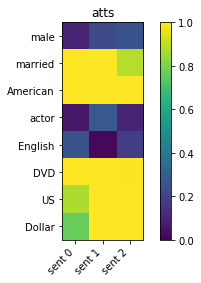

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [-12.501885   -6.4159117 -11.303033  -15.496746  -47.47239   -18.736319
 -20.253187  -18.882576 ]
pred = [0 0 0 0 0 0 0 0]
gt = [0 0 0 0 0 0 0 0]


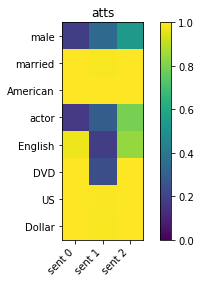

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [ -5.451787   -3.6561673  -5.0361304  -2.106398  -11.1282425  -6.1883645
  -6.7831836  -8.754873 ]
pred = [0 0 0 0 0 0 0 0]
gt = [0 0 0 0 0 0 0 0]


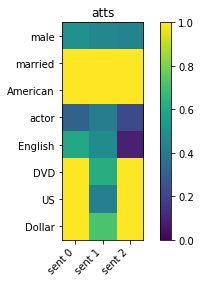

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [-2.057249   -1.1110923  -2.7235699  -4.151909   -1.9356768  -0.49281567
 -0.18970382 -1.9252353 ]
pred = [0 0 0 0 0 0 0 0]
gt = [0 1 0 1 0 0 0 0]


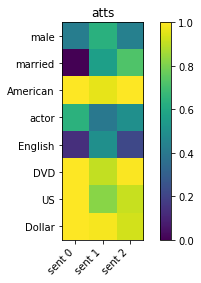

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [ 2.607394  -0.5276259 -3.7740574  1.1773088  4.8488965  6.7104917
  6.2194667  3.5071256]
pred = [1 0 0 1 1 1 1 1]
gt = [0 0 0 0 0 1 0 0]


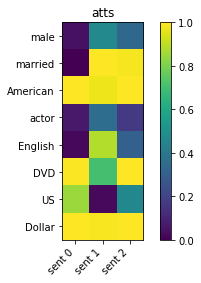

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [ 4.34184     1.7262965   0.6960758   0.30834973 -0.07568979 -4.6523905
 -5.1671257  -5.2774553 ]
pred = [1 1 1 1 0 0 0 0]
gt = [1 0 0 0 0 0 0 0]


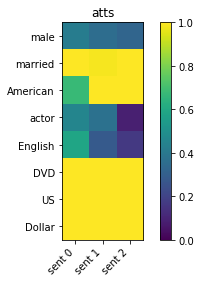

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [-3.1101418 -1.8509444 -4.25648   -3.731874   5.4443164  4.195756
  7.2507453  3.1439655]
pred = [0 0 0 0 1 1 1 1]
gt = [0 0 0 0 1 1 1 1]


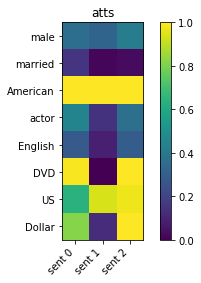

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [-3.1957898 -3.2687883 -2.5634036 -7.8538504 -6.689931  -6.423581
 -4.3667955 -5.577215 ]
pred = [0 0 0 0 0 0 0 0]
gt = [0 0 0 0 0 0 0 0]


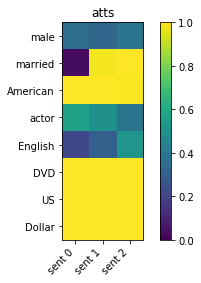

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [ -3.1567223   -3.106366    -5.764341   -13.250325    -0.9572232
   0.19797713  -1.0776566   -0.23435223]
pred = [0 0 0 0 0 1 0 0]
gt = [0 0 0 0 0 0 0 0]


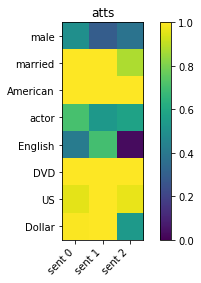

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [-0.7081271  -1.2236801  -1.5625678  -2.64781     1.8873764   1.0952094
  0.8884028  -0.10637915]
pred = [0 0 0 0 1 1 1 0]
gt = [0 0 0 0 1 1 1 1]


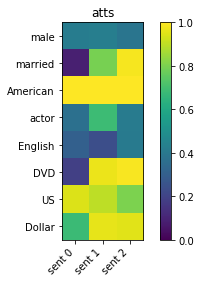

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [ -6.9780216  -1.245104   -3.8297105 -17.06618   -26.975752  -14.488231
 -14.231173  -11.521373 ]
pred = [0 0 0 0 0 0 0 0]
gt = [0 0 0 0 0 0 0 0]


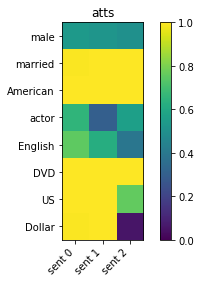

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [-1.1590564  -2.148323   -3.100205   -2.6344976   4.7350836  -0.9034072
  0.02429426  4.148156  ]
pred = [0 0 0 0 1 0 1 1]
gt = [0 0 0 0 0 0 0 0]


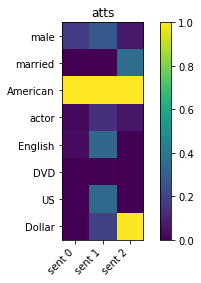

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [-10.922048   -2.6944256  -4.07863   -12.535472   -4.436368   -3.2875443
  -4.8022914  -4.7050123]
pred = [0 0 0 0 0 0 0 0]
gt = [0 0 0 0 0 0 0 0]


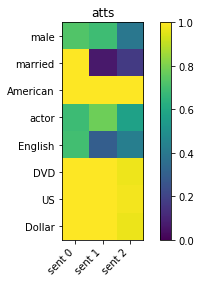

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [  5.9316072    5.328817     4.059187    -0.31920207 -19.191221
 -10.821339   -10.237609    -8.420579  ]
pred = [1 1 1 0 0 0 0 0]
gt = [1 0 0 0 0 0 0 0]


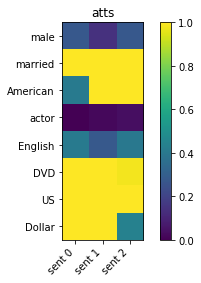

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [ 1.6210616  1.5971316 -3.0675855  8.011619  -4.3823757 -4.725304
 -5.0639524 -2.5052567]
pred = [1 1 0 1 0 0 0 0]
gt = [1 1 0 1 0 0 0 0]


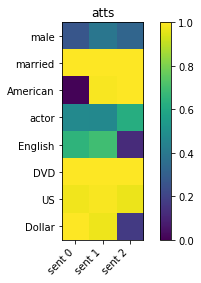

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [-2.601033  -1.8743298 -4.8600593 -9.02395   -8.929869  -6.553655
 -9.219795  -6.630314 ]
pred = [0 0 0 0 0 0 0 0]
gt = [0 0 0 0 0 0 0 0]


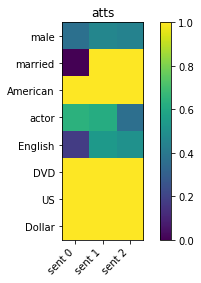

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [-2.6795177 -3.241002  -2.3147645 -8.038096  -6.993965  -3.162463
 -2.7149482 -2.9311352]
pred = [0 0 0 0 0 0 0 0]
gt = [0 0 0 0 0 0 0 0]


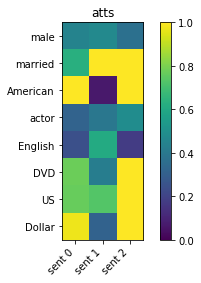

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [-4.258329  -4.237535  -4.788725  -7.4327803 -7.4916897 -4.3839536
 -4.044357  -5.5607185]
pred = [0 0 0 0 0 0 0 0]
gt = [0 0 0 0 0 0 0 0]


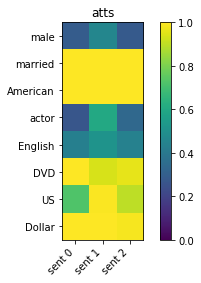

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [-4.979216  -3.3588095 -4.43688   -8.813671  -7.310522  -5.08471
 -4.6377807 -3.5077069]
pred = [0 0 0 0 0 0 0 0]
gt = [0 0 0 0 0 0 0 0]


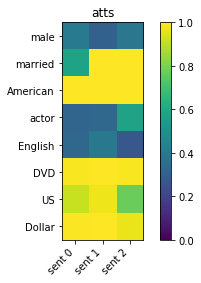

<IPython.core.display.HTML object>

male married American actor English DVD US Dollar
logits = [  1.0954189   2.3275204   3.807979   11.235652  -16.730362   -7.1587434
  -8.768829   -6.8712482]
pred = [1 1 1 1 0 0 0 0]
gt = [0 1 0 1 0 0 0 0]


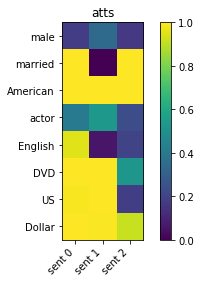

<IPython.core.display.HTML object>

In [10]:
ryn_dir = RynDir('Ryn Directory', ryn_dir_path)
ryn_dir.check()
rid_to_label = ryn_dir.split_dir.entity_labels_txt.load_rid_to_label()

for i in range(20):

    ent = ent_batch[i].item()

    display(HTML('<h1>{} ({})</h1>'.format(rid_to_label[ent], ent)))

    texts = [' '.join([vocab.itos[tok] if tok != 0 else '_' for tok in tok_list])
             for tok_list in sents_batch[i]]

    display(HTML(Template('''
        <ul>
            {% for text in texts %}
                <li> {{ text }} </li>
            {% endfor %}
        </ul>
    ''').render(texts=texts)))

    print('male', 'married', 'American', 'actor', 'English', 'DVD', 'US', 'Dollar')
    print('logits =', logits_batch[i].detach().numpy())
    print('pred =', pred_classes_batch[i].detach().numpy())
    print('gt =', gt_classes_batch[i].detach().numpy())

    class_labels = ['male', 'married', 'American', 'actor', 'English', 'DVD', 'US', 'Dollar']
    sent_labels = [f'sent {i}' for i in range(sent_count)]
    plot_tensor(debug['atts_batch'][i], 'atts', [class_labels, sent_labels], vmin=0, vmax=1)

    display(HTML(render_table(sents_batch[i])))